# dataprocessing Library
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# warnings ignore Library
import warnings
warnings.filterwarnings('ignore')

# Save ML model Library
import joblib

# Feature Tuning Library
import optuna

# Graph Explain Library
import plotly
from optuna.visualization import plot_optimization_history, plot_param_importances,\
                                 plot_parallel_coordinate, plot_rank, plot_slice

# Scikit-Learn Library
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import make_pipeline
from lightgbm.sklearn import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder

# eXplainable AI Library
import eli5
from alibi.explainers import PermutationImportance, PartialDependence, PartialDependenceVariance, ALE,\
                             plot_ale, plot_pd, plot_pd_variance, plot_permutation_importance

In [51]:
# NSL-KDD Datasets
df = pd.read_csv('../db/KDD_main.csv')
# NSL-KDD Columns
columns = (['duration','protocol_type','service'
            ,'flag','src_bytes','dst_bytes'
            ,'land','wrong_fragment','urgent'
            ,'hot','num_failed_logins','logged_in'
            ,'num_compromised','root_shell','su_attempted'
            ,'num_root','num_file_creations','num_shells'
            ,'num_access_files','num_outbound_cmds','is_host_login'
            ,'is_guest_login','count','srv_count'
            ,'serror_rate','srv_serror_rate','rerror_rate'
            ,'srv_rerror_rate','same_srv_rate','diff_srv_rate'
            ,'srv_diff_host_rate','dst_host_count','dst_host_srv_count'
            ,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate'
            ,'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate'
            ,'dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])
display(df)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37035,0,udp,domain_u,SF,43,43,0,0,0,0,...,1.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,normal,18
37036,0,tcp,http,SF,336,285,0,0,0,0,...,0.92,0.02,0.00,0.00,0.00,0.00,0.05,0.00,normal,18
37037,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.37,0.03,0.01,0.02,0.05,0.08,0.85,0.58,mscan,13
37038,0,tcp,sunrpc,REJ,0,0,0,0,0,0,...,0.19,0.03,0.01,0.04,0.00,0.00,0.88,1.00,mscan,15


---

In [52]:
# spy 데이터의 경우 전체 데이터셋에 하나밖에 존재하지 않아서, 모델 훈련에 어려움이 존재합니다.
# 가우시안 노이즈를 추가하여 데이터를 더 생성할 수 있겠지만, 모델의 신뢰도를 떨어트릴 수 있습니다.
# 데이터의 불균형을 예상하여 각각의 공격에 대한 예측이 아닌, 카테고리 기반 분류를 진행하겠습니다.
df['attack'].value_counts().tail()

attack
worm         2
udpstorm     2
perl         2
sqlattack    2
spy          1
Name: count, dtype: int64

In [53]:
# 정상 트래픽
normal = ["normal"]

# DoS (Denial of Service, 서비스 거부 공격)
dos = ["neptune", "smurf", "teardrop", "pod", "back", "land", 
       "apache2", "processtable", "mailbomb", "udpstorm"]

# Probing (탐색 공격, 정보 수집)
probing = ["ipsweep", "portsweep", "nmap", "satan", "mscan", "saint"]

# R2L (Remote to Local, 원격 침입 공격)
r2l = ["warezclient", "guess_passwd", "ftp_write", "multihop", "imap", 
       "warezmaster", "phf", "spy", "snmpguess", "httptunnel", 
       "snmpgetattack", "sendmail", "named"]

# U2R (User to Root, 권한 상승 공격)
u2r = ["rootkit", "buffer_overflow", "loadmodule", "ps", "xlock", 
       "xterm", "xsnoop", "perl", "sqlattack", "worm"]

# 각각의 데이터셋 변경
df.loc[df['attack'].isin(dos), 'attack'] = 'DOS_Attack'
df.loc[df['attack'].isin(r2l), 'attack'] = 'R2L_Attack'
df.loc[df['attack'].isin(u2r), 'attack'] = 'U2R_Attack'
df.loc[df['attack'].isin(probing), 'attack'] = 'PROBING_Attack'
df.loc[df['attack'].isin(['normal']), 'attack'] = 'NORMAL'
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,NORMAL,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DOS_Attack,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,NORMAL,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NORMAL,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,DOS_Attack,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37035,0,udp,domain_u,SF,43,43,0,0,0,0,...,1.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,NORMAL,18
37036,0,tcp,http,SF,336,285,0,0,0,0,...,0.92,0.02,0.00,0.00,0.00,0.00,0.05,0.00,NORMAL,18
37037,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.37,0.03,0.01,0.02,0.05,0.08,0.85,0.58,PROBING_Attack,13
37038,0,tcp,sunrpc,REJ,0,0,0,0,0,0,...,0.19,0.03,0.01,0.04,0.00,0.00,0.88,1.00,PROBING_Attack,15


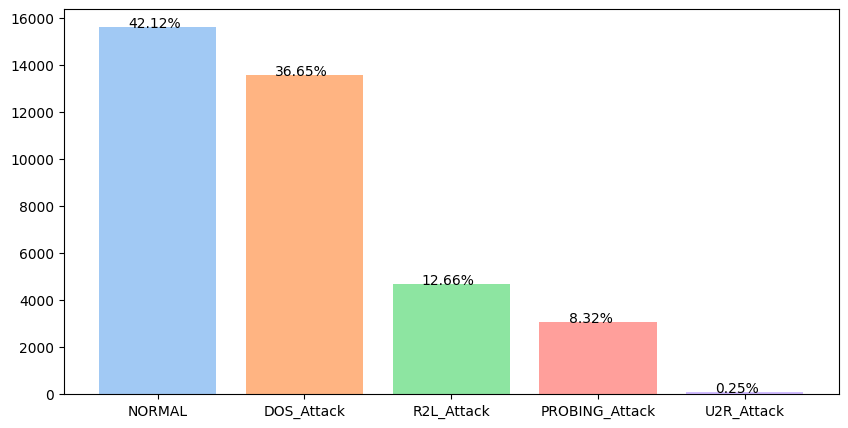

In [54]:
# Target 데이터에 대한 분포입니다.
target_distribution = df['attack'].value_counts().values
color = sns.color_palette(palette='pastel')
plt.figure(figsize=(10, 5))
plt.bar(df['attack'].unique(), target_distribution, color=[i for i in color])
height = -0.2
for i in range(len(target_distribution)):
    plt.text(height, target_distribution[i], f'{round(target_distribution[i]/sum(target_distribution)*100, 2)}%')
    height+=1

In [55]:
# Train 데이터와 Target 데이터를 먼저 분류
X = df.drop(columns='attack')
y = df['attack']

# 훈련, 테스트 데이터로 분류 / 데이터 불균형으로 인하여 stratify의 값을 y로 설정
train_input, test_input, train_target, test_target = train_test_split(X, y,
                                                                      stratify=y, test_size=.2,
                                                                      random_state=42)

# ColumnTransformer을 사용하기 위해서 수치형 특성과 범주형 특성으로 분류
cat_features = ['protocol_type', 'service', 'flag']
num_features = [i for i in X.columns if i not in cat_features]

# 전처리기 생성
le = LabelEncoder()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features)
    ]
)

# Train, Target 데이터 정제
train_scaled = preprocessor.fit_transform(train_input)
test_scaled = preprocessor.transform(test_input)
train_target = le.fit_transform(train_target)
test_target = le.transform(test_target)

In [56]:
# 가장 먼저, personr 함수를 사용해서 유의수준을 만족하지 못하는 변수를 제외합니다.
for i in range(train_scaled.shape[1]):
    corr, p_value = stats.pearsonr(train_scaled[:, i], train_target)
    if p_value >= 0.05:
        print('--------------------------------------------------------------------')
        print(f'특성 "{X.columns[i]}"의 p-value 값은 {round(p_value, 4)}로 유의수준을 만족하지 않습니다.')
print('--------------------------------------------------------------------')

# 유의수준 만족하지 못하는 feature drop
X = X.drop(columns=['hot', 'logged_in', 'num_compromised'])
y = df['attack']

# 재분류
train_input, test_input, train_target, test_target = train_test_split(X, y,
                                                                      stratify=y, test_size=.2,
                                                                      random_state=42)

# 특성 분류
cat_features = ['protocol_type', 'service', 'flag']
num_features = [i for i in X.columns if i not in cat_features]

# 전처리기 생성
le = LabelEncoder()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features)
    ]
)

# 데이터 전처리
train_scaled = preprocessor.fit_transform(train_input)
test_scaled = preprocessor.transform(test_input)
train_target = le.fit_transform(train_target)
test_target = le.transform(test_target)

--------------------------------------------------------------------
특성 "hot"의 p-value 값은 0.3248로 유의수준을 만족하지 않습니다.
--------------------------------------------------------------------
특성 "logged_in"의 p-value 값은 0.7583로 유의수준을 만족하지 않습니다.
--------------------------------------------------------------------
특성 "num_compromised"의 p-value 값은 0.2839로 유의수준을 만족하지 않습니다.
--------------------------------------------------------------------


---

In [57]:
# 초기 모델 훈련 / Parameter Tuning 없이 진행
lr_pipeline = make_pipeline(preprocessor,
                            LogisticRegression())
lr_pipeline.fit(train_input, train_target)
lr_train_pred = lr_pipeline.predict(train_input)
lr_test_pred = lr_pipeline.predict(test_input)
print('-'*60)
print(f'Logistic Regression에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(lr_train_pred, train_target), 4)}')
print(f'Logistic Regression에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(lr_test_pred, test_target), 4)}')
print(f'Logistic Regression에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(lr_train_pred, train_target), 4)}')
print(f'Logistic Regression에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(lr_test_pred, test_target), 4)}')
print('-'*60)

------------------------------------------------------------
Logistic Regression에서의 Accuracy_Score -> 훈련세트 점수 0.9238
Logistic Regression에서의 Accuracy_Score -> 테스트세트 점수 0.9222
Logistic Regression에서의 Balanced_Score -> 훈련세트 점수 0.8682
Logistic Regression에서의 Balanced_Score -> 테스트세트 점수 0.8433
------------------------------------------------------------


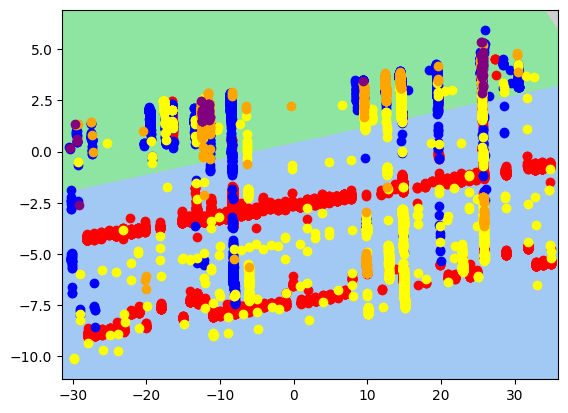

In [58]:
# 특성을 2개로 줄여, 결정경계 그래프를 그린다.
pca = PCA(n_components=2)
train_pca = pca.fit_transform(pd.DataFrame(train_scaled, columns=X.columns))
test_pca = pca.transform(pd.DataFrame(test_scaled, columns=X.columns))

x_min, x_max = train_pca[:, 0].min()-1, train_pca[:, 0].max()+1
y_min, y_max = train_pca[:, 1].min()-1, train_pca[:, 1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
lr = LogisticRegression()
lr.fit(train_pca, train_target)
z = lr.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

# 
color = sns.color_palette('pastel')
plt.contourf(xx, yy, z, colors=color)
colors = ['red', 'blue', 'yellow', 'orange', 'purple']
for i in np.unique(train_target):
    plt.scatter(train_pca[train_target==i][:, 0], train_pca[train_target==i][:, 1], c=colors[i])

In [59]:
# 랜덤포레스트로도 훈련결과를 보겠습니다.
rf_pipeline = make_pipeline(preprocessor,
                            RandomForestClassifier())
rf_pipeline.fit(train_input, train_target)
rf_train_pred = rf_pipeline.predict(train_input)
rf_test_pred = rf_pipeline.predict(test_input)
print('-'*60)
print(f'RandomForestClassifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(rf_train_pred, train_target), 4)}')
print(f'RandomForestClassifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(rf_test_pred, test_target), 4)}')
print(f'RandomForestClassifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(rf_train_pred, train_target), 4)}')
print(f'RandomForestClassifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(rf_test_pred, test_target), 4)}')
print('-'*60)

------------------------------------------------------------
RandomForestClassifier에서의 Accuracy_Score -> 훈련세트 점수 1.0
RandomForestClassifier에서의 Accuracy_Score -> 테스트세트 점수 0.9957
RandomForestClassifier에서의 Balanced_Score -> 훈련세트 점수 1.0
RandomForestClassifier에서의 Balanced_Score -> 테스트세트 점수 0.9522
------------------------------------------------------------


<Axes: >

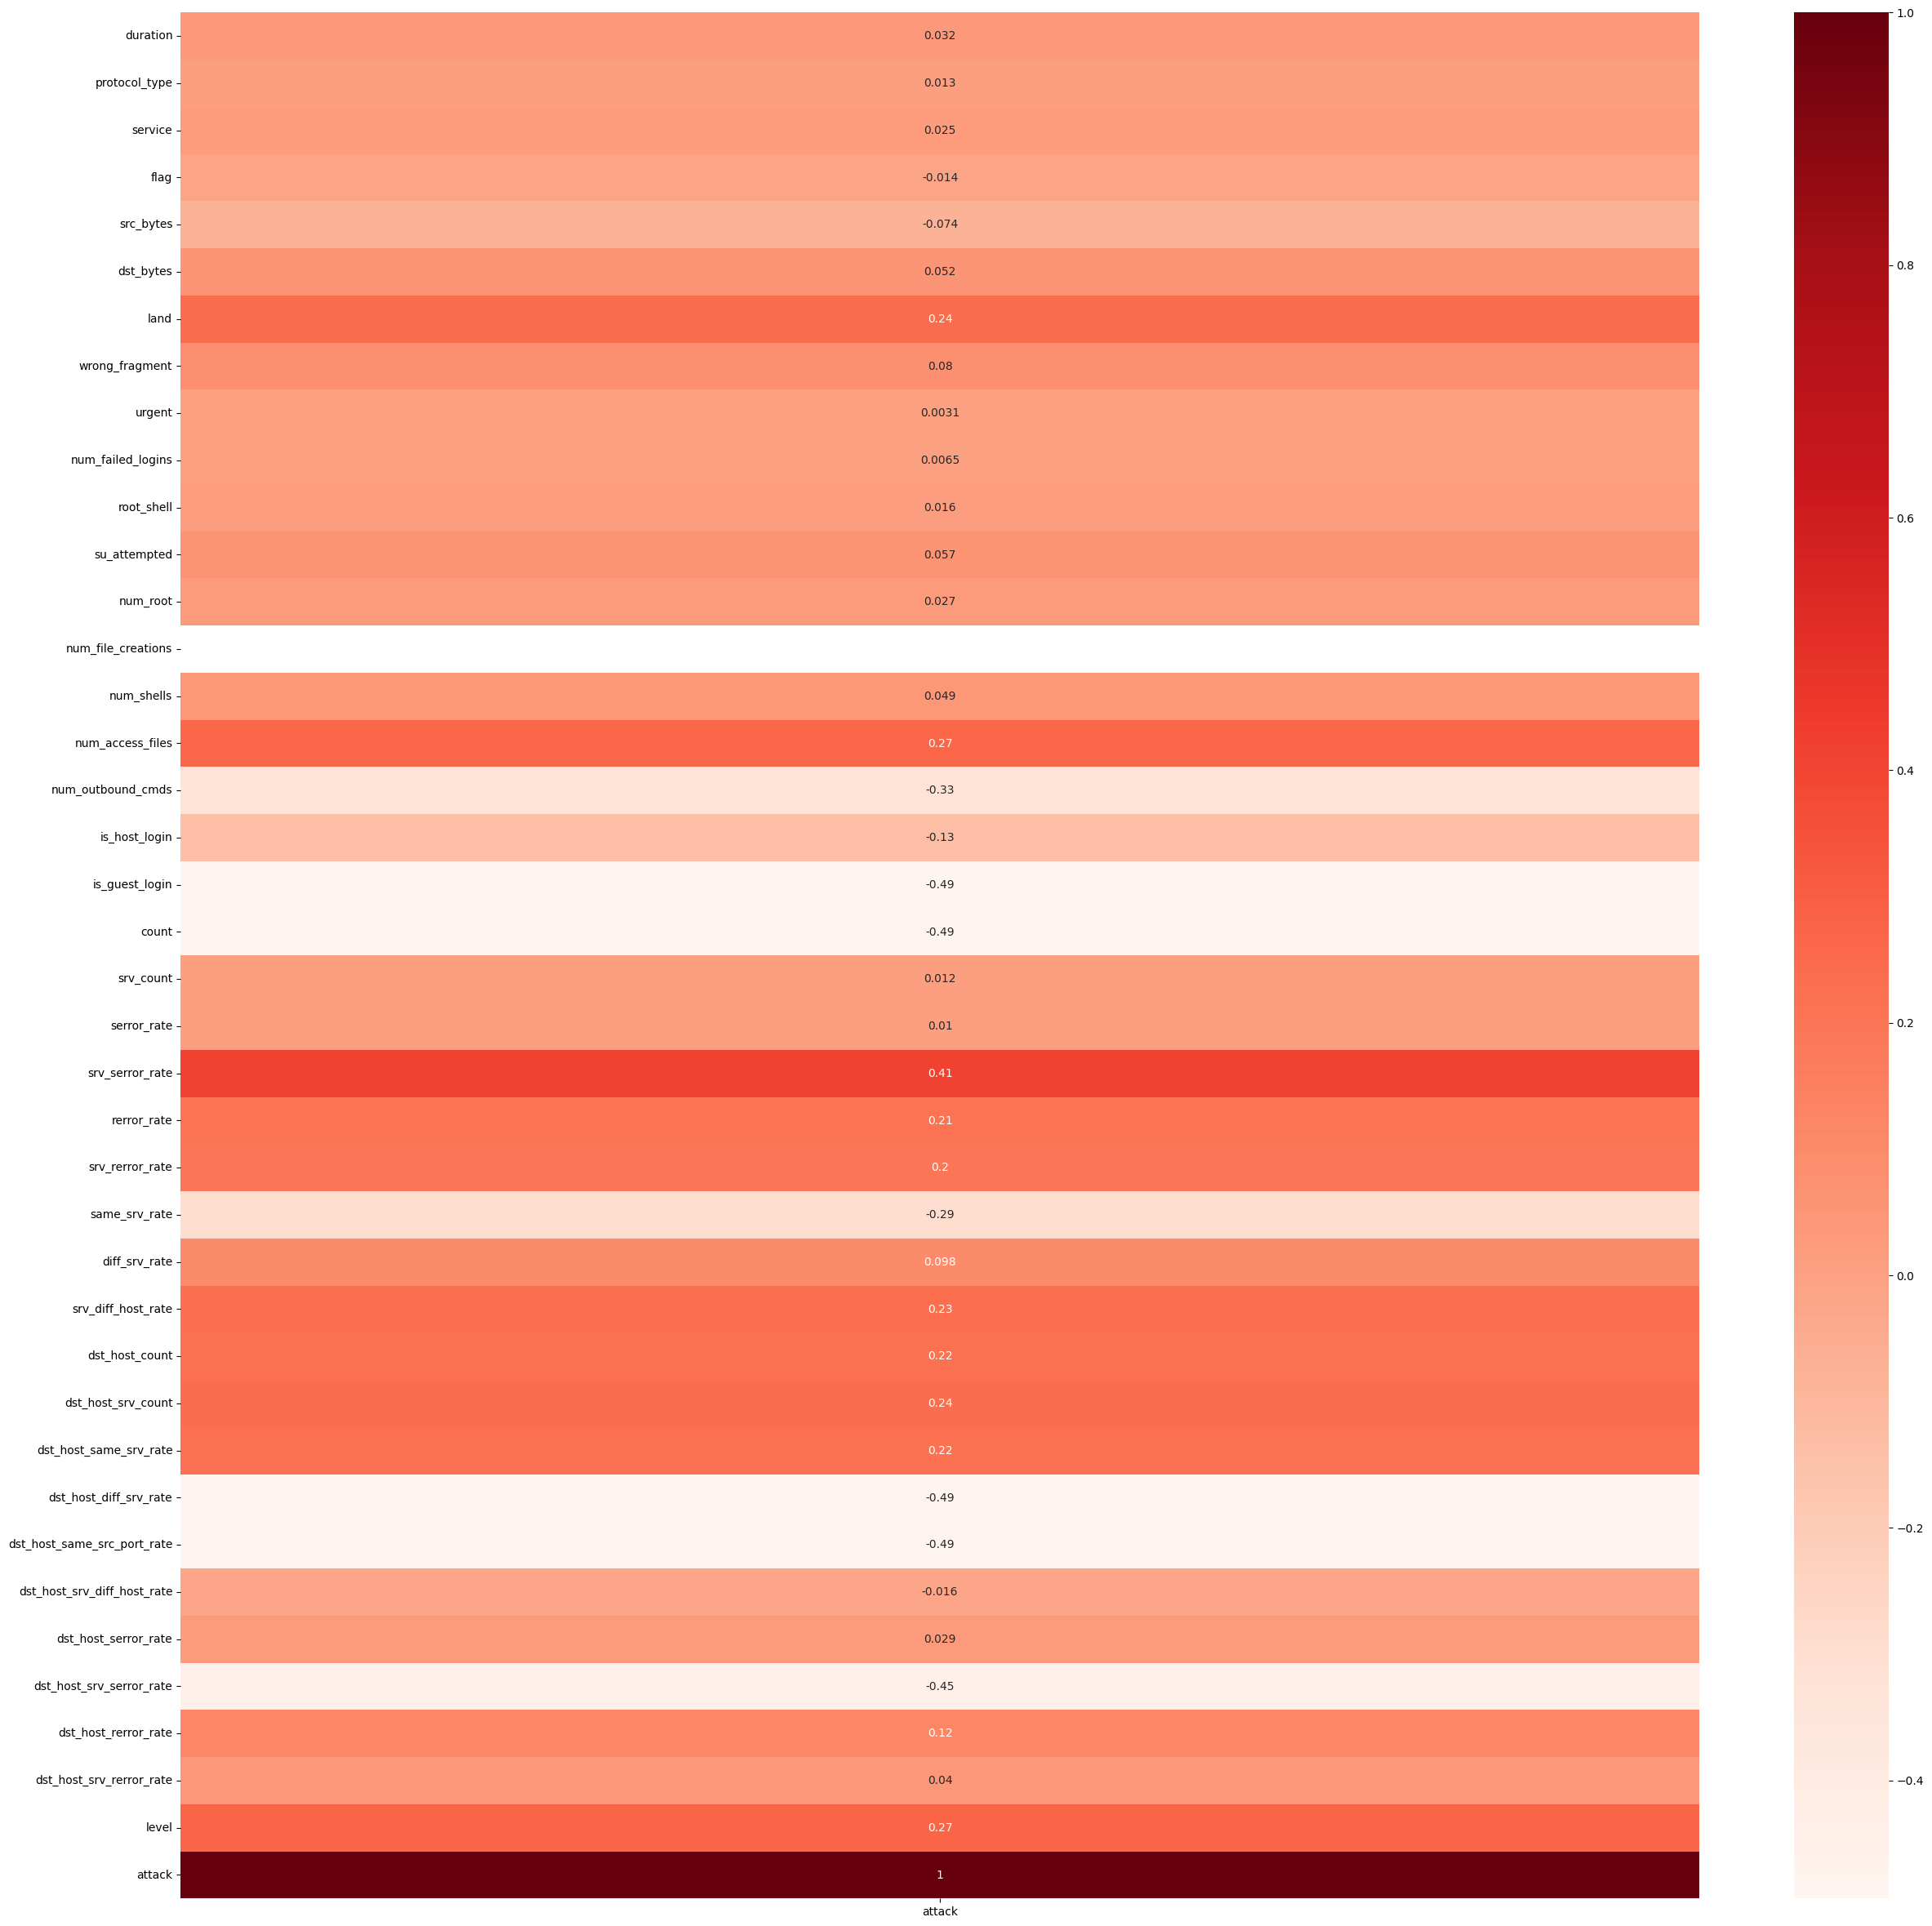

In [60]:
# Target에 대한 Feature들의 상관관계를 살펴볼게요!
corr_X = pd.DataFrame(preprocessor.fit_transform(X), columns=X.columns)
corr_y = pd.DataFrame(le.fit_transform(y), columns=['attack'])
plt.figure(figsize=(30, 30))
sns.heatmap(pd.concat(objs=[corr_X, corr_y], axis=1).corr()[['attack']], annot=True, cmap='Reds')

<Axes: >

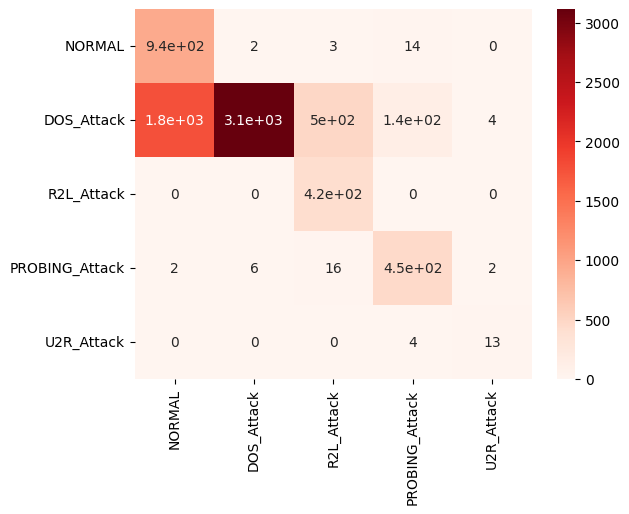

In [61]:
# 랜덤포레스트의 정확도를 보기위해서 혼동행렬을 사용해줄게요.
cm = confusion_matrix(rf_pipeline.predict(test_input), test_target)
sns.heatmap(cm, cmap='Reds', annot=True, xticklabels=y.unique(), yticklabels=y.unique())

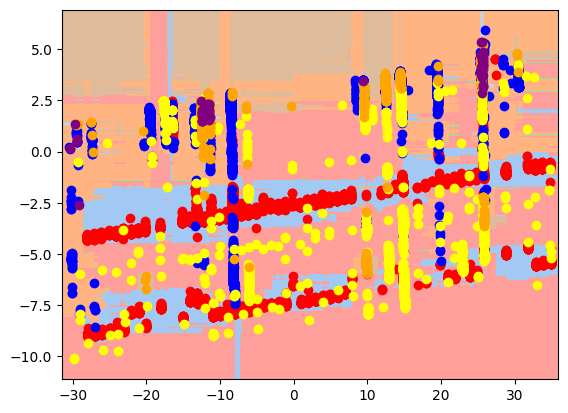

In [62]:
# 랜덤포레스트도 결정경계를 그려볼게요.
pca = PCA(n_components=2)
train_pca = pca.fit_transform(pd.DataFrame(train_scaled, columns=X.columns))
test_pca = pca.transform(pd.DataFrame(test_scaled, columns=X.columns))

x_min, x_max = train_pca[:, 0].min()-1, train_pca[:, 0].max()+1
y_min, y_max = train_pca[:, 1].min()-1, train_pca[:, 1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
rf = RandomForestClassifier()
rf.fit(train_pca, train_target)
z = rf.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

color = sns.color_palette('pastel')
plt.contourf(xx, yy, z, colors=color)
colors = ['red', 'blue', 'yellow', 'orange', 'purple']
for i in np.unique(train_target):
    plt.scatter(train_pca[train_target==i][:, 0], train_pca[train_target==i][:, 1], c=colors[i])

In [63]:
# DecisionTreeClassifier 훈련결과를 보겠습니다.
dt_pipeline = make_pipeline(preprocessor,
                            DecisionTreeClassifier())
dt_pipeline.fit(train_input, train_target)
print('-'*60)
print(f'DecisionTreeClassifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(dt_pipeline.predict(train_input), train_target), 4)}')
print(f'DecisionTreeClassifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(dt_pipeline.predict(test_input), test_target), 4)}')
print(f'DecisionTreeClassifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(dt_pipeline.predict(train_input), train_target), 4)}')
print(f'DecisionTreeClassifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(dt_pipeline.predict(test_input), test_target), 4)}')
print('-'*60)

------------------------------------------------------------
DecisionTreeClassifier에서의 Accuracy_Score -> 훈련세트 점수 1.0
DecisionTreeClassifier에서의 Accuracy_Score -> 테스트세트 점수 0.991
DecisionTreeClassifier에서의 Balanced_Score -> 훈련세트 점수 1.0
DecisionTreeClassifier에서의 Balanced_Score -> 테스트세트 점수 0.8872
------------------------------------------------------------


In [44]:
# xgboost 훈련결과를 보겠습니다.
xgb_pipeline = make_pipeline(preprocessor,
                            XGBClassifier())
xgb_pipeline.fit(train_input, train_target)
print('-'*60)
print(f'XGBootClassifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(xgb_pipeline.predict(train_input), train_target), 4)}')
print(f'XGBootClassifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(xgb_pipeline.predict(test_input), test_target), 4)}')
print(f'XGBootClassifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(xgb_pipeline.predict(train_input), train_target), 4)}')
print(f'XGBootClassifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(xgb_pipeline.predict(test_input), test_target), 4)}')
print('-'*60)

------------------------------------------------------------
XGBootClassifier에서의 Accuracy_Score -> 훈련세트 점수 1.0
XGBootClassifier에서의 Accuracy_Score -> 테스트세트 점수 0.9966
XGBootClassifier에서의 Balanced_Score -> 훈련세트 점수 1.0
XGBootClassifier에서의 Balanced_Score -> 테스트세트 점수 0.9482
------------------------------------------------------------


In [64]:
# lightgbm 훈련결과를 보겠습니다.
lgb_pipe = make_pipeline(preprocessor,
                            LGBMClassifier())
lgb_pipe.fit(train_input, train_target)
print('-'*60)
print(f'LightGBMClasifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(lgb_pipe.predict(train_input), train_target), 4)}')
print(f'LightGBMClasifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(lgb_pipe.predict(test_input), test_target), 4)}')
print(f'LightGBMClasifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(lgb_pipe.predict(train_input), train_target), 4)}')
print(f'LightGBMClasifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(lgb_pipe.predict(test_input), test_target), 4)}')
print('-'*60)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3058
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 35
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

---

In [15]:
# eli5를 이용해서 중요한 특성 5개를 살펴볼게요.
lr = LogisticRegression()
lr.fit(train_scaled, train_target)
eli5.explain_weights(lr, feature_names=preprocessor.feature_names_in_, top=5)

Explanation(estimator='LogisticRegression()', description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='dst_host_srv_diff_host_rate', weight=1.3361539404650529, std=None, value=None), FeatureWeight(feature='num_outbound_cmds', weight=0.9278284698687203, std=None, value=None)], neg=[FeatureWeight(feature='dst_host_rerror_rate', weight=-2.358694612674273, std=None, value=None), FeatureWeight(feature='srv_serror_rate', weight=-1.2532206468069451, std=None, value=None), FeatureWeight(feature='rerror_rate', weight=-1.0259712783213846, std=None, value=None)], pos_remaining=16, neg_remaining=18), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='dst_host_rerror_rate', weight=2.2893101868910346, std=None, value=None), FeatureWeight(feature='dst_host_srv_serror_rate', weight=1.500099497530656, std=None, value=None), FeatureWeight(feature='is_host_login', weight=0.6711899728308592, std=None, value=None)], neg=[FeatureWeight(feature='same_srv_rate', weight=-1.0097956812188902, std=None, value=None), FeatureWeight(feature='srv_diff_host_rate', weight=-0.8294532422913323, std=None, value=None)], pos_remaining=19, neg_remaining=15), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target=2, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='dst_host_srv_count', weight=1.1164471084064835, std=None, value=None), FeatureWeight(feature='srv_rerror_rate', weight=0.9026776948924026, std=None, value=None), FeatureWeight(feature='rerror_rate', weight=0.6118746634337644, std=None, value=None)], neg=[FeatureWeight(feature='srv_diff_host_rate', weight=-0.7173521035909224, std=None, value=None), FeatureWeight(feature='src_bytes', weight=-0.6539424783418402, std=None, value=None)], pos_remaining=17, neg_remaining=17), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target=3, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='srv_diff_host_rate', weight=0.8926791465440503, std=None, value=None), FeatureWeight(feature='num_access_files', weight=0.8152483706530865, std=None, value=None)], neg=[FeatureWeight(feature='dst_host_srv_diff_host_rate', weight=-0.7970439781771713, std=None, value=None), FeatureWeight(feature='srv_rerror_rate', weight=-0.7771905814418608, std=None, value=None), FeatureWeight(feature='is_host_login', weight=-0.7454471398648397, std=None, value=None)], pos_remaining=13, neg_remaining=21), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target=4, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='wrong_fragment', weight=0.28916791827757615, std=None, value=None), FeatureWeight(feature='su_attempted', weight=0.2520407860793027, std=None, value=None), FeatureWeight(feature='protocol_type', weight=0.19282128462938522, std=None, value=None)], neg=[FeatureWeight(feature='dst_host_srv_serror_rate', weight=-0.5953135364444325, std=None, value=None), FeatureWeight(feature='level', weight=-0.20654278631384063, std=None, value=None)], pos_remaining=10, neg_remaining=24), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [16]:
# 랜덤포레스트도요!
rf = RandomForestClassifier()
rf.fit(train_scaled, train_target)
eli5.explain_weights(rf, feature_names=preprocessor.feature_names_in_, top=5)

Explanation(estimator='RandomForestClassifier()', description='\nRandom forest feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='protocol_type', weight=0.13155109559421013, std=0.11112768674216104, value=None), FeatureWeight(feature='dst_host_srv_serror_rate', weight=0.1174089413501353, std=0.05235445436193101, value=None), FeatureWeight(feature='service', weight=0.08550713166473319, std=0.08953764723725134, value=None), FeatureWeight(feature='srv_serror_rate', weight=0.04745195639160779, std=0.08224869264030867, value=None), FeatureWeight(feature='level', weight=0.04711826595327768, std=0.08745072104177382, value=None)], remaining=34), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [17]:
# 총 5개의 모델에 대해서, 상위 5개의 Feature들만 고르겠습니다.
dt = DecisionTreeClassifier()
dt.fit(train_scaled, train_target)
dt_feature_df = pd.DataFrame(dt.feature_importances_, 
                              index=preprocessor.feature_names_in_).sort_values(by=0, ascending=False).head(5)
dt_big_impt_feature = dt_feature_df.index.tolist()

xgb = XGBClassifier()
xgb.fit(train_scaled, train_target)
xgb_feature_df = pd.DataFrame(xgb.feature_importances_, 
                              index=preprocessor.feature_names_in_).sort_values(by=0, ascending=False).head(5)
xgb_big_impt_feature = xgb_feature_df.index.tolist()

lgbm = LGBMClassifier()
lgbm.fit(train_scaled, train_target)
lgbm_feature_df = pd.DataFrame(lgbm.feature_importances_, 
                              index=preprocessor.feature_names_in_).sort_values(by=0, ascending=False).head(5)
lgbm_big_impt_feature = lgbm_feature_df.index.tolist()

rf_feature_df = eli5.explain_weights_df(rf, feature_names=preprocessor.feature_names_in_, top=5)
rf_feature_df['impt'] = rf_feature_df['weight']+rf_feature_df['std']
rf_big_impt_feature = rf_feature_df.head()['feature'].tolist()

lr_feature_df = eli5.explain_weights_df(lr, feature_names=preprocessor.feature_names_in_, top=5)
all_impt_feature = list()
for i in range(5):
    all_impt_feature.append(lr_feature_df.loc[lr_feature_df['target']==i, 'feature'].tolist())
real_impt_feature = list()
for i in range(5):
    for j in all_impt_feature[i]:
        real_impt_feature.append(j)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3058
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 35
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [18]:
# 중요한 Feature들을 합쳐서, 중복을 제거해줍시다.
real_impt_feature = list(set(dt_big_impt_feature+xgb_big_impt_feature+lgbm_big_impt_feature+\
                             real_impt_feature+rf_big_impt_feature))
print(len(real_impt_feature))

20


---

In [65]:
# 선택된 데이터셋을 바탕으로 모델을 다시 훈련시킵시다.
X = df[real_impt_feature]
y = df['attack']

le = LabelEncoder()
cat_features = ['service', 'protocol_type']
num_features = [i for i in X.columns if i not in cat_features]

train_input, test_input, train_target, test_target = train_test_split(X, y,
                                                                      stratify=y, test_size=.2,
                                                                      random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)
train_target = le.fit_transform(train_target)
test_target = le.transform(test_target)

In [67]:
# 중요한 특성만 골랐는데, 결과값은 어떻게 변했는지 확인해보죠!
lr_pipeline = make_pipeline(preprocessor,
                            LogisticRegression())
lr_pipeline.fit(train_input, train_target)
print('-'*60)
print(f'Logistic Regression에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(lr_pipeline.predict(train_input), train_target), 4)}')
print(f'Logistic Regression에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(lr_pipeline.predict(test_input), test_target), 4)}')
print(f'Logistic Regression에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(lr_pipeline.predict(train_input), train_target), 4)}')
print(f'Logistic Regression에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(lr_pipeline.predict(test_input), test_target), 4)}')
print('-'*60)

------------------------------------------------------------
Logistic Regression에서의 Accuracy_Score -> 훈련세트 점수 0.9357
Logistic Regression에서의 Accuracy_Score -> 테스트세트 점수 0.9326
Logistic Regression에서의 Balanced_Score -> 훈련세트 점수 0.8789
Logistic Regression에서의 Balanced_Score -> 테스트세트 점수 0.8395
------------------------------------------------------------


In [69]:
# DecisionTreeClassifier 훈련결과를 보겠습니다.
dt_pipeline = make_pipeline(preprocessor,
                            DecisionTreeClassifier())
dt_pipeline.fit(train_input, train_target)
print('-'*60)
print(f'DecisionTreeClassifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(dt_pipeline.predict(train_input), train_target), 4)}')
print(f'DecisionTreeClassifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(dt_pipeline.predict(test_input), test_target), 4)}')
print(f'DecisionTreeClassifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(dt_pipeline.predict(train_input), train_target), 4)}')
print(f'DecisionTreeClassifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(dt_pipeline.predict(test_input), test_target), 4)}')
print('-'*60)

rf_pipeline = make_pipeline(preprocessor,
                            RandomForestClassifier())
rf_pipeline.fit(train_input, train_target)
print('-'*60)
print(f'RandomForestClassifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(rf_pipeline.predict(train_input), train_target), 4)}')
print(f'RandomForestClassifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(rf_pipeline.predict(test_input), test_target), 4)}')
print(f'RandomForestClassifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(rf_pipeline.predict(train_input), train_target), 4)}')
print(f'RandomForestClassifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(rf_pipeline.predict(test_input), test_target), 4)}')
print('-'*60)

xgb_pipeline = make_pipeline(preprocessor,
                             XGBClassifier())
xgb_pipeline.fit(train_input, train_target)
print('-'*60)
print(f'XGBootClassifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(xgb_pipeline.predict(train_input), train_target), 4)}')
print(f'XGBootClassifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(xgb_pipeline.predict(test_input), test_target), 4)}')
print(f'XGBootClassifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(xgb_pipeline.predict(train_input), train_target), 4)}')
print(f'XGBootClassifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(xgb_pipeline.predict(test_input), test_target), 4)}')
print('-'*60)


# lightgbm 훈련결과를 보겠습니다.
lgb_pipe = make_pipeline(preprocessor,
                            LGBMClassifier())
lgb_pipe.fit(train_input, train_target)
print('-'*60)
print(f'LightGBMClasifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(lgb_pipe.predict(train_input), train_target), 4)}')
print(f'LightGBMClasifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(lgb_pipe.predict(test_input), test_target), 4)}')
print(f'LightGBMClasifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(lgb_pipe.predict(train_input), train_target), 4)}')
print(f'LightGBMClasifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(lgb_pipe.predict(test_input), test_target), 4)}')
print('-'*60)

------------------------------------------------------------
DecisionTreeClassifier에서의 Accuracy_Score -> 훈련세트 점수 1.0
DecisionTreeClassifier에서의 Accuracy_Score -> 테스트세트 점수 0.9911
DecisionTreeClassifier에서의 Balanced_Score -> 훈련세트 점수 1.0
DecisionTreeClassifier에서의 Balanced_Score -> 테스트세트 점수 0.9279
------------------------------------------------------------
------------------------------------------------------------
RandomForestClassifier에서의 Accuracy_Score -> 훈련세트 점수 1.0
RandomForestClassifier에서의 Accuracy_Score -> 테스트세트 점수 0.9954
RandomForestClassifier에서의 Balanced_Score -> 훈련세트 점수 1.0
RandomForestClassifier에서의 Balanced_Score -> 테스트세트 점수 0.9562
------------------------------------------------------------
------------------------------------------------------------
XGBootClassifier에서의 Accuracy_Score -> 훈련세트 점수 1.0
XGBootClassifier에서의 Accuracy_Score -> 테스트세트 점수 0.9951
XGBootClassifier에서의 Balanced_Score -> 훈련세트 점수 1.0
XGBootClassifier에서의 Balanced_Score -> 테스트세트 점수 0.927
------------------------

---

In [83]:
# ALE는 수치형 특성에 대한 함수이므로, 수치형 특성만 골라줄게요.
X = df[real_impt_feature]
y = df['attack']
cat_features = ['service', 'protocol_type']
num_features = [i for i in X.columns if i not in cat_features]
num_and_real_feature = [i for i in real_impt_feature if i not in cat_features]
target_names = y.unique()

X = X[num_and_real_feature]


train_input, test_input, train_target, test_target = train_test_split(X, y,
                                                                      stratify=y, test_size=.2,
                                                                      random_state=42)

In [84]:
# 확실히 수치형만 있으면 결과값이 낮네요. 범주형 특성이 주는 영향력이 생각보다 큰가봅니다.
lr = LogisticRegression(random_state=42)
lr.fit(train_input, train_target)
lr.score(train_input, train_target)

0.5304738120950324

In [85]:
# 아래 두가지 식을 구해주고요
proba_ale_lr = ALE(predictor=lr.predict_proba, feature_names=num_and_real_feature,
                   target_names=target_names)
proba_exp_lr = proba_ale_lr.explain(train_input.values)

array([[<Axes: xlabel='srv_diff_host_rate', ylabel='ALE'>,
        <Axes: xlabel='rerror_rate', ylabel='ALE'>,
        <Axes: xlabel='src_bytes', ylabel='ALE'>],
       [<Axes: xlabel='same_srv_rate', ylabel='ALE'>,
        <Axes: xlabel='dst_host_srv_diff_host_rate', ylabel='ALE'>,
        <Axes: xlabel='level', ylabel='ALE'>],
       [<Axes: xlabel='srv_rerror_rate', ylabel='ALE'>,
        <Axes: xlabel='dst_host_srv_count', ylabel='ALE'>,
        <Axes: xlabel='num_access_files', ylabel='ALE'>],
       [<Axes: xlabel='is_host_login', ylabel='ALE'>,
        <Axes: xlabel='dst_host_same_src_port_rate', ylabel='ALE'>,
        <Axes: xlabel='dst_host_rerror_rate', ylabel='ALE'>],
       [<Axes: xlabel='su_attempted', ylabel='ALE'>,
        <Axes: xlabel='wrong_fragment', ylabel='ALE'>,
        <Axes: xlabel='srv_serror_rate', ylabel='ALE'>],
       [<Axes: xlabel='dst_host_srv_serror_rate', ylabel='ALE'>,
        <Axes: xlabel='dst_host_srv_rerror_rate', ylabel='ALE'>,
        <Axes: xl

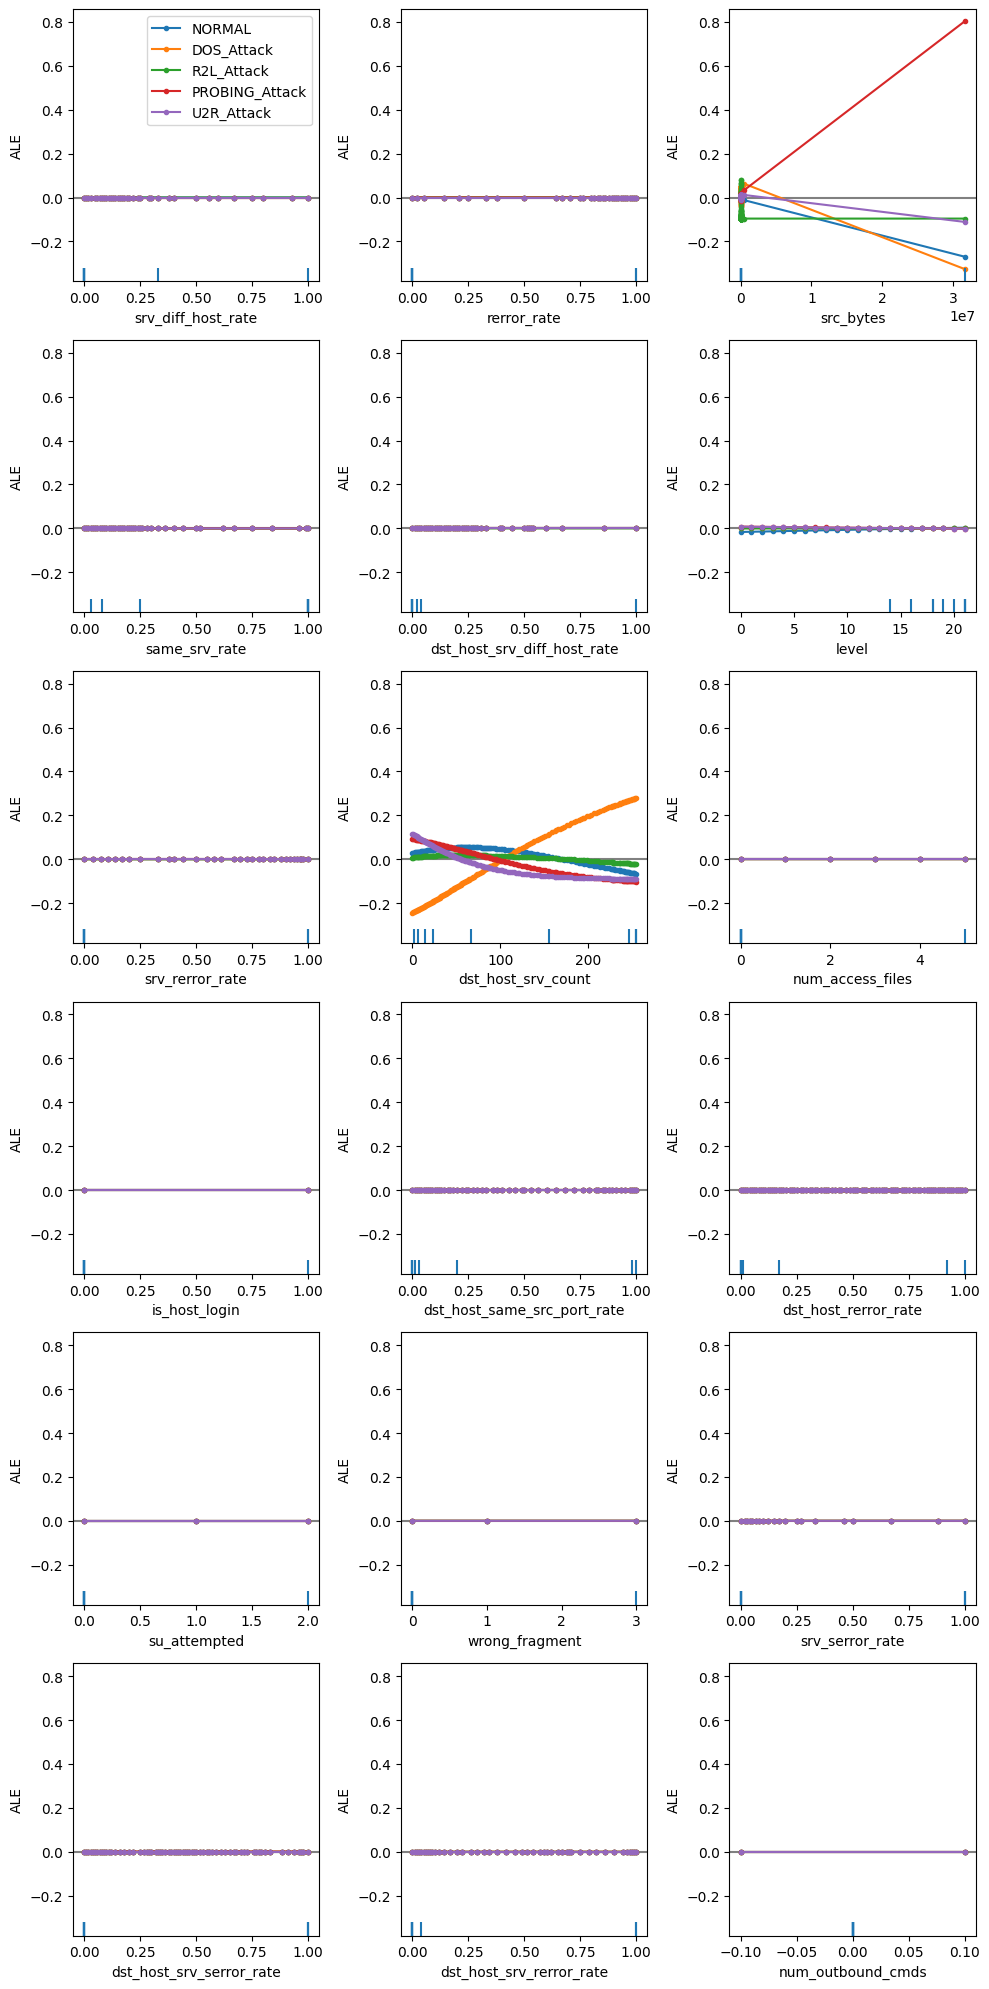

In [86]:
# 도식화 시켜보겠습니다.
plot_ale(exp=proba_exp_lr, fig_kw={'figwidth':10, 'figheight':20}, n_cols=3)

In [87]:
# 특성중에서 영향력이 없는 특성은 지워줄게요.
num_and_real_feature.remove('num_outbound_cmds')

In [89]:
# 다시 수치형과 범주형 특성들을 합쳐주고요
selected_features = num_and_real_feature+cat_features
len(selected_features)

19

In [90]:
# 마지막으로 데이터를 선택해줄게요.
featured_data = df[selected_features]
featured_target = df['attack']

train_input, test_input, train_target, test__target = train_test_split(featured_data, featured_target,
                                                                       stratify=featured_target, test_size=.2,
                                                                       random_state=42)

le = LabelEncoder()
train_target = le.fit_transform(train_target)
test_target = le.transform(test__target)

cat_features = ['service', 'protocol_type']
num_features = [i for i in featured_data.columns if i not in cat_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_features)
    ]
)

In [92]:
# 라벨인코더는 0, 1, 2, 3, 4에 대해서 다음 순서로 값을 할당했습니다.
le.classes_

array(['DOS_Attack', 'NORMAL', 'PROBING_Attack', 'R2L_Attack',
       'U2R_Attack'], dtype=object)

In [93]:
# 중요한 특성만 골랐는데, 결과값은 어떻게 변했는지 확인해보죠!
lr_pipeline = make_pipeline(preprocessor,
                            LogisticRegression())
lr_pipeline.fit(train_input, train_target)
print('-'*60)
print(f'Logistic Regression에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(lr_pipeline.predict(train_input), train_target), 4)}')
print(f'Logistic Regression에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(lr_pipeline.predict(test_input), test_target), 4)}')
print(f'Logistic Regression에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(lr_pipeline.predict(train_input), train_target), 4)}')
print(f'Logistic Regression에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(lr_pipeline.predict(test_input), test_target), 4)}')
print('-'*60)

# DecisionTreeClassifier 훈련결과를 보겠습니다.
dt_pipeline = make_pipeline(preprocessor,
                            DecisionTreeClassifier())
dt_pipeline.fit(train_input, train_target)
print('-'*60)
print(f'DecisionTreeClassifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(dt_pipeline.predict(train_input), train_target), 4)}')
print(f'DecisionTreeClassifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(dt_pipeline.predict(test_input), test_target), 4)}')
print(f'DecisionTreeClassifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(dt_pipeline.predict(train_input), train_target), 4)}')
print(f'DecisionTreeClassifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(dt_pipeline.predict(test_input), test_target), 4)}')
print('-'*60)

rf_pipeline = make_pipeline(preprocessor,
                            RandomForestClassifier())
rf_pipeline.fit(train_input, train_target)
print('-'*60)
print(f'RandomForestClassifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(rf_pipeline.predict(train_input), train_target), 4)}')
print(f'RandomForestClassifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(rf_pipeline.predict(test_input), test_target), 4)}')
print(f'RandomForestClassifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(rf_pipeline.predict(train_input), train_target), 4)}')
print(f'RandomForestClassifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(rf_pipeline.predict(test_input), test_target), 4)}')
print('-'*60)

xgb_pipeline = make_pipeline(preprocessor,
                             XGBClassifier())
xgb_pipeline.fit(train_input, train_target)
print('-'*60)
print(f'XGBootClassifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(xgb_pipeline.predict(train_input), train_target), 4)}')
print(f'XGBootClassifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(xgb_pipeline.predict(test_input), test_target), 4)}')
print(f'XGBootClassifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(xgb_pipeline.predict(train_input), train_target), 4)}')
print(f'XGBootClassifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(xgb_pipeline.predict(test_input), test_target), 4)}')
print('-'*60)


# lightgbm 훈련결과를 보겠습니다.
lgb_pipe = make_pipeline(preprocessor,
                            LGBMClassifier())
lgb_pipe.fit(train_input, train_target)
print('-'*60)
print(f'LightGBMClasifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(lgb_pipe.predict(train_input), train_target), 4)}')
print(f'LightGBMClasifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(lgb_pipe.predict(test_input), test_target), 4)}')
print(f'LightGBMClasifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(lgb_pipe.predict(train_input), train_target), 4)}')
print(f'LightGBMClasifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(lgb_pipe.predict(test_input), test_target), 4)}')
print('-'*60)

------------------------------------------------------------
Logistic Regression에서의 Accuracy_Score -> 훈련세트 점수 0.9357
Logistic Regression에서의 Accuracy_Score -> 테스트세트 점수 0.9326
Logistic Regression에서의 Balanced_Score -> 훈련세트 점수 0.8789
Logistic Regression에서의 Balanced_Score -> 테스트세트 점수 0.8395
------------------------------------------------------------
------------------------------------------------------------
DecisionTreeClassifier에서의 Accuracy_Score -> 훈련세트 점수 1.0
DecisionTreeClassifier에서의 Accuracy_Score -> 테스트세트 점수 0.9906
DecisionTreeClassifier에서의 Balanced_Score -> 훈련세트 점수 1.0
DecisionTreeClassifier에서의 Balanced_Score -> 테스트세트 점수 0.9194
------------------------------------------------------------
------------------------------------------------------------
RandomForestClassifier에서의 Accuracy_Score -> 훈련세트 점수 1.0
RandomForestClassifier에서의 Accuracy_Score -> 테스트세트 점수 0.9955
RandomForestClassifier에서의 Balanced_Score -> 훈련세트 점수 1.0
RandomForestClassifier에서의 Balanced_Score -> 테스트세트 점수 0.9538
-----

In [94]:
# 로지스틱 모델 튜닝
def log_tune(trial):
    try:
        penalty = trial.suggest_categorical('penalty', ['l2'])
        C = trial.suggest_float("C", 1e-7, 1e3, log=True)
        solver = trial.suggest_categorical("solver", ['lbfgs', 'liblinear', 'saga'])
        max_iter = trial.suggest_int('max_iter', 1, 100)
        
        log_pipe = make_pipeline(preprocessor, LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=max_iter,
                                                                  random_state=42))
        log_pipe.fit(train_input, train_target)
        
        val_accuracy = log_pipe.score(test_input, test_target)
        return val_accuracy
    except (TypeError, ValueError):
        return np.nan

log_study = optuna.create_study(sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
    direction="maximize")
log_study.optimize(n_trials=30, n_jobs=-1, func=log_tune)

[I 2025-03-21 23:50:08,156] A new study created in memory with name: no-name-93117ddb-2611-4e41-9fbe-32f0bb92a9c3
[I 2025-03-21 23:50:10,006] Trial 3 finished with value: 0.8257289416846653 and parameters: {'penalty': 'l2', 'C': 0.04312017752905168, 'solver': 'saga', 'max_iter': 3}. Best is trial 3 with value: 0.8257289416846653.
[I 2025-03-21 23:50:10,038] Trial 0 finished with value: 0.8713552915766739 and parameters: {'penalty': 'l2', 'C': 0.013723263289693333, 'solver': 'saga', 'max_iter': 9}. Best is trial 0 with value: 0.8713552915766739.
[I 2025-03-21 23:50:11,547] Trial 4 finished with value: 0.9055075593952484 and parameters: {'penalty': 'l2', 'C': 2.192874863077323, 'solver': 'saga', 'max_iter': 18}. Best is trial 4 with value: 0.9055075593952484.
[I 2025-03-21 23:50:13,248] Trial 7 finished with value: 0.9233261339092873 and parameters: {'penalty': 'l2', 'C': 4.331372893068462, 'solver': 'liblinear', 'max_iter': 75}. Best is trial 7 with value: 0.9233261339092873.
[I 2025-03

In [95]:
# 서포트벡터머신 튜닝
def svm_tune(trial):
    try:
        C = trial.suggest_float('C', 1e-7, 1e3)
        max_iter = trial.suggest_int('max_iter', 1, 100)
    
        svm_pipe = make_pipeline(preprocessor, SVC(C=C, max_iter=max_iter, random_state=42))
        svm_pipe.fit(train_input, train_target)
    
        accuracy_score = svm_pipe.score(test_input, test_target)
        return accuracy_score
    except (ValueError, TypeError):
        return np.nan
svm_study = optuna.create_study(sampler=optuna.samplers.TPESampler(),
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                                direction='maximize')
svm_study.optimize(func=svm_tune, n_trials=30, show_progress_bar=True)

[I 2025-03-21 23:53:50,185] A new study created in memory with name: no-name-d625227a-eb75-43b8-a50c-4e9454f4616b
Best trial: 0. Best value: 0.806156:   3%|▎         | 1/30 [00:01<00:38,  1.32s/it]

[I 2025-03-21 23:53:51,578] Trial 0 finished with value: 0.8061555075593952 and parameters: {'C': 516.8815342037562, 'max_iter': 89}. Best is trial 0 with value: 0.8061555075593952.


Best trial: 1. Best value: 0.80791:  10%|█         | 3/30 [00:02<00:20,  1.34it/s] 

[I 2025-03-21 23:53:52,789] Trial 1 finished with value: 0.8079103671706264 and parameters: {'C': 261.16423010506867, 'max_iter': 86}. Best is trial 1 with value: 0.8079103671706264.
[I 2025-03-21 23:53:52,930] Trial 2 finished with value: 0.38390928725701945 and parameters: {'C': 424.90708638639774, 'max_iter': 4}. Best is trial 1 with value: 0.8079103671706264.


Best trial: 3. Best value: 0.840308:  13%|█▎        | 4/30 [00:03<00:24,  1.07it/s]

[I 2025-03-21 23:53:54,148] Trial 3 finished with value: 0.8403077753779697 and parameters: {'C': 447.75899710098696, 'max_iter': 82}. Best is trial 3 with value: 0.8403077753779697.


Best trial: 3. Best value: 0.840308:  17%|█▋        | 5/30 [00:05<00:30,  1.21s/it]

[I 2025-03-21 23:53:55,861] Trial 4 finished with value: 0.8273488120950324 and parameters: {'C': 41.23032550231786, 'max_iter': 91}. Best is trial 3 with value: 0.8403077753779697.


Best trial: 3. Best value: 0.840308:  20%|██        | 6/30 [00:06<00:26,  1.12s/it]

[I 2025-03-21 23:53:56,799] Trial 5 finished with value: 0.6862850971922246 and parameters: {'C': 468.0120331605117, 'max_iter': 49}. Best is trial 3 with value: 0.8403077753779697.


Best trial: 3. Best value: 0.840308:  23%|██▎       | 7/30 [00:07<00:23,  1.03s/it]

[I 2025-03-21 23:53:57,632] Trial 6 finished with value: 0.5109341252699784 and parameters: {'C': 660.5829108428899, 'max_iter': 49}. Best is trial 3 with value: 0.8403077753779697.


Best trial: 3. Best value: 0.840308:  27%|██▋       | 8/30 [00:07<00:18,  1.19it/s]

[I 2025-03-21 23:53:58,069] Trial 7 finished with value: 0.3698704103671706 and parameters: {'C': 719.591324903921, 'max_iter': 20}. Best is trial 3 with value: 0.8403077753779697.


Best trial: 3. Best value: 0.840308:  30%|███       | 9/30 [00:08<00:18,  1.16it/s]

[I 2025-03-21 23:53:58,973] Trial 8 finished with value: 0.5492710583153347 and parameters: {'C': 706.403405129225, 'max_iter': 65}. Best is trial 3 with value: 0.8403077753779697.


Best trial: 3. Best value: 0.840308:  33%|███▎      | 10/30 [00:09<00:19,  1.02it/s]

[I 2025-03-21 23:54:00,217] Trial 9 finished with value: 0.7849622030237581 and parameters: {'C': 79.73515865385359, 'max_iter': 75}. Best is trial 3 with value: 0.8403077753779697.


Best trial: 3. Best value: 0.840308:  37%|███▋      | 11/30 [00:10<00:16,  1.16it/s]

[I 2025-03-21 23:54:00,828] Trial 10 finished with value: 0.3548866090712743 and parameters: {'C': 859.8077586528268, 'max_iter': 33}. Best is trial 3 with value: 0.8403077753779697.


Best trial: 11. Best value: 0.88013:  40%|████      | 12/30 [00:12<00:19,  1.09s/it]

[I 2025-03-21 23:54:02,418] Trial 11 finished with value: 0.8801295896328294 and parameters: {'C': 36.49439411674766, 'max_iter': 94}. Best is trial 11 with value: 0.8801295896328294.


Best trial: 11. Best value: 0.88013:  43%|████▎     | 13/30 [00:17<00:38,  2.27s/it]

[I 2025-03-21 23:54:07,422] Trial 12 finished with value: 0.8470572354211663 and parameters: {'C': 238.2767722756588, 'max_iter': 100}. Best is trial 11 with value: 0.8801295896328294.


Best trial: 11. Best value: 0.88013:  47%|████▋     | 14/30 [00:18<00:32,  2.03s/it]

[I 2025-03-21 23:54:08,889] Trial 13 finished with value: 0.8392278617710583 and parameters: {'C': 207.5326403966019, 'max_iter': 100}. Best is trial 11 with value: 0.8801295896328294.


Best trial: 11. Best value: 0.88013:  50%|█████     | 15/30 [00:19<00:26,  1.74s/it]

[I 2025-03-21 23:54:09,969] Trial 14 finished with value: 0.5697894168466523 and parameters: {'C': 224.38480603470722, 'max_iter': 61}. Best is trial 11 with value: 0.8801295896328294.


Best trial: 15. Best value: 0.885124:  53%|█████▎    | 16/30 [00:21<00:25,  1.81s/it]

[I 2025-03-21 23:54:11,950] Trial 15 finished with value: 0.8851241900647948 and parameters: {'C': 7.111708120183959, 'max_iter': 100}. Best is trial 15 with value: 0.8851241900647948.


Best trial: 15. Best value: 0.885124:  57%|█████▋    | 17/30 [00:23<00:23,  1.82s/it]

[I 2025-03-21 23:54:13,789] Trial 16 finished with value: 0.5128239740820735 and parameters: {'C': 1.596972589367339, 'max_iter': 72}. Best is trial 15 with value: 0.8851241900647948.


Best trial: 15. Best value: 0.885124:  60%|██████    | 18/30 [00:24<00:18,  1.52s/it]

[I 2025-03-21 23:54:14,592] Trial 17 finished with value: 0.5454913606911447 and parameters: {'C': 127.15470770577349, 'max_iter': 38}. Best is trial 15 with value: 0.8851241900647948.


Best trial: 15. Best value: 0.885124:  63%|██████▎   | 19/30 [00:25<00:16,  1.47s/it]

[I 2025-03-21 23:54:15,942] Trial 18 finished with value: 0.7782127429805615 and parameters: {'C': 356.3114162074422, 'max_iter': 100}. Best is trial 15 with value: 0.8851241900647948.


Best trial: 15. Best value: 0.885124:  67%|██████▋   | 20/30 [00:26<00:13,  1.35s/it]

[I 2025-03-21 23:54:17,033] Trial 19 finished with value: 0.6919546436285097 and parameters: {'C': 135.08052794068462, 'max_iter': 61}. Best is trial 15 with value: 0.8851241900647948.


Best trial: 15. Best value: 0.885124:  70%|███████   | 21/30 [00:27<00:11,  1.29s/it]

[I 2025-03-21 23:54:18,182] Trial 20 finished with value: 0.7146328293736501 and parameters: {'C': 992.4312717528112, 'max_iter': 78}. Best is trial 15 with value: 0.8851241900647948.


Best trial: 15. Best value: 0.885124:  73%|███████▎  | 22/30 [00:29<00:10,  1.29s/it]

[I 2025-03-21 23:54:19,461] Trial 21 finished with value: 0.7702483801295896 and parameters: {'C': 300.45486512432564, 'max_iter': 94}. Best is trial 15 with value: 0.8851241900647948.


Best trial: 15. Best value: 0.885124:  77%|███████▋  | 23/30 [00:30<00:09,  1.36s/it]

[I 2025-03-21 23:54:20,984] Trial 22 finished with value: 0.8056155507559395 and parameters: {'C': 136.6104268712046, 'max_iter': 99}. Best is trial 15 with value: 0.8851241900647948.


Best trial: 15. Best value: 0.885124:  80%|████████  | 24/30 [00:32<00:08,  1.43s/it]

[I 2025-03-21 23:54:22,574] Trial 23 finished with value: 0.8732451403887689 and parameters: {'C': 20.27466642765099, 'max_iter': 86}. Best is trial 15 with value: 0.8851241900647948.


Best trial: 15. Best value: 0.885124:  83%|████████▎ | 25/30 [00:34<00:07,  1.59s/it]

[I 2025-03-21 23:54:24,547] Trial 24 finished with value: 0.7522948164146869 and parameters: {'C': 1.1123298021869434, 'max_iter': 84}. Best is trial 15 with value: 0.8851241900647948.


Best trial: 15. Best value: 0.885124:  87%|████████▋ | 26/30 [00:35<00:05,  1.48s/it]

[I 2025-03-21 23:54:25,769] Trial 25 finished with value: 0.8481371490280778 and parameters: {'C': 85.02910179679853, 'max_iter': 69}. Best is trial 15 with value: 0.8851241900647948.


Best trial: 15. Best value: 0.885124:  90%|█████████ | 27/30 [00:36<00:04,  1.44s/it]

[I 2025-03-21 23:54:27,099] Trial 26 finished with value: 0.8272138228941684 and parameters: {'C': 173.83071783349823, 'max_iter': 91}. Best is trial 15 with value: 0.8851241900647948.


Best trial: 15. Best value: 0.885124:  93%|█████████▎| 28/30 [00:37<00:02,  1.34s/it]

[I 2025-03-21 23:54:28,206] Trial 27 finished with value: 0.5221382289416847 and parameters: {'C': 344.22594978426, 'max_iter': 79}. Best is trial 15 with value: 0.8851241900647948.


Best trial: 15. Best value: 0.885124:  97%|█████████▋| 29/30 [00:39<00:01,  1.37s/it]

[I 2025-03-21 23:54:29,645] Trial 28 finished with value: 0.8829643628509719 and parameters: {'C': 66.16712995161183, 'max_iter': 92}. Best is trial 15 with value: 0.8851241900647948.


Best trial: 15. Best value: 0.885124: 100%|██████████| 30/30 [00:40<00:00,  1.35s/it]

[I 2025-03-21 23:54:30,789] Trial 29 finished with value: 0.8610961123110151 and parameters: {'C': 534.8822340430352, 'max_iter': 92}. Best is trial 15 with value: 0.8851241900647948.


In [96]:
# 랜덤포레스트 모델 튜닝
def rf_tune(trial):
    try:
        n_estimators = trial.suggest_int('n_estimators', 50, 500)
        max_depth = trial.suggest_int('max_depth', 5, 50)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        max_samples = trial.suggest_float('max_samples', 0.5, 1.0)
    
        rf_pipe = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                                                     min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                                                     max_features=max_features, max_samples=max_samples, random_state=42))
        rf_pipe.fit(train_input, train_target)
        accuracy_score = rf_pipe.score(test_input, test_target)
        return accuracy_score
    except (TypeError, ValueError):
        return 0

rf_study = optuna.create_study(sampler=optuna.samplers.TPESampler(),
                               pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                               direction='maximize')
rf_study.optimize(func=rf_tune, n_trials=30)

[I 2025-03-21 23:54:30,796] A new study created in memory with name: no-name-6ae723b5-efa4-4c3e-91f2-8f081b06ad8f
[I 2025-03-21 23:54:32,559] Trial 0 finished with value: 0.9913606911447084 and parameters: {'n_estimators': 186, 'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_samples': 0.9922446862317543}. Best is trial 0 with value: 0.9913606911447084.
[I 2025-03-21 23:54:34,712] Trial 1 finished with value: 0.9937904967602592 and parameters: {'n_estimators': 203, 'max_depth': 27, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_samples': 0.9520515162513978}. Best is trial 1 with value: 0.9937904967602592.
[I 2025-03-21 23:54:36,699] Trial 2 finished with value: 0.9937904967602592 and parameters: {'n_estimators': 251, 'max_depth': 35, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_samples': 0.6938753715681885}. Best is trial 1 with value: 0.9937904967602592.
[I 2025-03-21 23:54:38,999]

In [97]:
# xgboost 모델 튜닝
def xgb_tune(trial):
    try:
        learning_rate = trial.suggest_float('learning_rate', 0, 1)
        n_estimators = trial.suggest_int('n_estimators', 50, 500)
        max_depth = trial.suggest_int('max_depth', 5, 50)
    
        xgb_pipe = make_pipeline(preprocessor, XGBClassifier(learning_rate=learning_rate,
                                                             n_estimators=n_estimators,
                                                             max_depth=max_depth,
                                                             random_state=42))
        xgb_pipe.fit(train_input, train_target)
        accuracy_score = xgb_pipe.score(test_input, test_target)
        return accuracy_score
    except (TypeError, ValueError):
        return 0
xgb_study = optuna.create_study(sampler=optuna.samplers.TPESampler(),
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                                direction='maximize')
xgb_study.optimize(func=xgb_tune, n_trials=30)

[I 2025-03-21 23:55:48,291] A new study created in memory with name: no-name-d564b454-4e54-467c-87c6-3a9fcf33650c
[I 2025-03-21 23:55:51,459] Trial 0 finished with value: 0.9950053995680346 and parameters: {'learning_rate': 0.9089015880178876, 'n_estimators': 382, 'max_depth': 21}. Best is trial 0 with value: 0.9950053995680346.
[I 2025-03-21 23:55:53,975] Trial 1 finished with value: 0.9954103671706264 and parameters: {'learning_rate': 0.8775845244647613, 'n_estimators': 300, 'max_depth': 5}. Best is trial 1 with value: 0.9954103671706264.
[I 2025-03-21 23:55:58,690] Trial 2 finished with value: 0.9954103671706264 and parameters: {'learning_rate': 0.1391285017930337, 'n_estimators': 372, 'max_depth': 35}. Best is trial 1 with value: 0.9954103671706264.
[I 2025-03-21 23:56:01,923] Trial 3 finished with value: 0.9952753779697624 and parameters: {'learning_rate': 0.9857698995239562, 'n_estimators': 418, 'max_depth': 41}. Best is trial 1 with value: 0.9954103671706264.
[I 2025-03-21 23:56

In [98]:
# lgb모델 튜닝
def lgb_tune(trial):
    try:
        learning_rate = trial.suggest_float('learning_rate', 0, 1)
        n_estimators = trial.suggest_int('n_estimators', 50, 500)
        max_depth = trial.suggest_int('max_depth', 5, 50)
        lgb_pipe = make_pipeline(preprocessor, LGBMClassifier(learning_rate=learning_rate,
                                                              n_estimators=n_estimators,
                                                              max_depth=max_depth,
                                                              random_state=42))
        lgb_pipe.fit(train_input, train_target)
        accuracy_score = lgb_pipe.score(test_input, test_target)
        return accuracy_score
    except (TypeError, ValueError):
        return 0
lgb_study = optuna.create_study(sampler=optuna.samplers.TPESampler(),
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                                direction='maximize')
lgb_study.optimize(func=lgb_tune, n_trials=30)

[I 2025-03-21 23:57:05,461] A new study created in memory with name: no-name-ba54e8d1-98e3-4e37-8fb0-2b71fd666d62


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-03-21 23:57:07,025] Trial 0 finished with value: 0.3169546436285097 and parameters: {'learning_rate': 0.465960138888875, 'n_estimators': 479, 'max_depth': 29}. Best is trial 0 with value: 0.3169546436285097.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[I 2025-03-21 23:57:09,162] Trial 1 finished with value: 0.7687634989200864 and parameters: {'learning_rate': 0.20347811197622623, 'n_estimators': 395, 'max_depth': 31}. Best is trial 1 with value: 0.7687634989200864.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-03-21 23:57:10,317] Trial 2 finished with value: 0.46692764578833695 and parameters: {'learning_rate': 0.6172318492274, 'n_estimators': 308, 'max_depth': 46}. Best is trial 1 with value: 0.7687634989200864.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[I 2025-03-21 23:57:11,207] Trial 3 finished with value: 0.8624460043196545 and parameters: {'learning_rate': 0.5668175761026655, 'n_estimators': 117, 'max_depth': 9}. Best is trial 3 with value: 0.8624460043196545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-03-21 23:57:12,502] Trial 4 finished with value: 0.595707343412527 and parameters: {'learning_rate': 0.9996658069350234, 'n_estimators': 486, 'max_depth': 46}. Best is trial 3 with value: 0.8624460043196545.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-03-21 23:57:13,589] Trial 5 finished with value: 0.6636069114470843 and parameters: {'learning_rate': 0.6478472975936431, 'n_estimators': 251, 'max_depth': 27}. Best is trial 3 with value: 0.8624460043196545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[I 2025-03-21 23:57:16,910] Trial 6 finished with value: 0.6645518358531317 and parameters: {'learning_rate': 0.1372939169197357, 'n_estimators': 360, 'max_depth': 16}. Best is trial 3 with value: 0.8624460043196545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[I 2025-03-21 23:57:17,909] Trial 7 finished with value: 0.7875269978401728 and parameters: {'learning_rate': 0.9256849318714245, 'n_estimators': 349, 'max_depth': 47}. Best is trial 3 with value: 0.8624460043196545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[I 2025-03-21 23:57:19,439] Trial 8 finished with value: 0.8168196544276458 and parameters: {'learning_rate': 0.26844506573351645, 'n_estimators': 353, 'max_depth': 6}. Best is trial 3 with value: 0.8624460043196545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-03-21 23:57:20,198] Trial 9 finished with value: 0.5606101511879049 and parameters: {'learning_rate': 0.6092887096324943, 'n_estimators': 282, 'max_depth': 5}. Best is trial 3 with value: 0.8624460043196545.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-03-21 23:57:21,174] Trial 10 finished with value: 0.652267818574514 and parameters: {'learning_rate': 0.40932214315929544, 'n_estimators': 95, 'max_depth': 17}. Best is trial 3 with value: 0.8624460043196545.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-03-21 23:57:22,344] Trial 11 finished with value: 0.6517278617710583 and parameters: {'learning_rate': 0.28481075192489774, 'n_estimators': 147, 'max_depth': 5}. Best is trial 3 with value: 0.8624460043196545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-21 23:57:26,756] Trial 12 finished with value: 0.9767818574514039 and parameters: {'learning_rate': 0.0019956535120991825, 'n_estimators': 197, 'max_depth': 13}. Best is trial 12 with value: 0.9767818574514039.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-21 23:57:31,429] Trial 13 finished with value: 0.9948704103671706 and parameters: {'learning_rate': 0.06207822126739635, 'n_estimators': 195, 'max_depth': 15}. Best is trial 13 with value: 0.9948704103671706.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-21 23:57:35,936] Trial 14 finished with value: 0.9917656587473002 and parameters: {'learning_rate': 0.008265686590893346, 'n_estimators': 198, 'max_depth': 19}. Best is trial 13 with value: 0.9948704103671706.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-21 23:57:39,911] Trial 15 finished with value: 0.7794276457883369 and parameters: {'learning_rate': 0.0004068245347298438, 'n_estimators': 177, 'max_depth': 22}. Best is trial 13 with value: 0.9948704103671706.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-21 23:57:41,168] Trial 16 finished with value: 0.994060475161987 and parameters: {'learning_rate': 0.08432527099850758, 'n_estimators': 52, 'max_depth': 38}. Best is trial 13 with value: 0.9948704103671706.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-21 23:57:42,509] Trial 17 finished with value: 0.9817764578833693 and parameters: {'learning_rate': 0.13877009295006693, 'n_estimators': 56, 'max_depth': 37}. Best is trial 13 with value: 0.9948704103671706.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-03-21 23:57:43,206] Trial 18 finished with value: 0.6173056155507559 and parameters: {'learning_rate': 0.7760645941268098, 'n_estimators': 81, 'max_depth': 38}. Best is trial 13 with value: 0.9948704103671706.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-03-21 23:57:44,513] Trial 19 finished with value: 0.8332883369330454 and parameters: {'learning_rate': 0.37238167958435, 'n_estimators': 238, 'max_depth': 39}. Best is trial 13 with value: 0.9948704103671706.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-03-21 23:57:47,105] Trial 20 finished with value: 0.7818574514038877 and parameters: {'learning_rate': 0.1288469598012469, 'n_estimators': 138, 'max_depth': 22}. Best is trial 13 with value: 0.9948704103671706.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stop

[I 2025-03-21 23:57:51,933] Trial 21 finished with value: 0.9951403887688985 and parameters: {'learning_rate': 0.05843972834291128, 'n_estimators': 204, 'max_depth': 22}. Best is trial 21 with value: 0.9951403887688985.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-03-21 23:57:56,584] Trial 22 finished with value: 0.9950053995680346 and parameters: {'learning_rate': 0.11161939159754132, 'n_estimators': 226, 'max_depth': 25}. Best is trial 21 with value: 0.9951403887688985.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-03-21 23:57:58,501] Trial 23 finished with value: 0.8178995680345572 and parameters: {'learning_rate': 0.23972071558329838, 'n_estimators': 241, 'max_depth': 25}. Best is trial 21 with value: 0.9951403887688985.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-03-21 23:57:59,797] Trial 24 finished with value: 0.5036447084233261 and parameters: {'learning_rate': 0.3381165989294165, 'n_estimators': 164, 'max_depth': 12}. Best is trial 21 with value: 0.9951403887688985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[I 2025-03-21 23:58:04,627] Trial 25 finished with value: 0.9952753779697624 and parameters: {'learning_rate': 0.0888743591770349, 'n_estimators': 208, 'max_depth': 33}. Best is trial 25 with value: 0.9952753779697624.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-03-21 23:58:07,044] Trial 26 finished with value: 0.41279697624190065 and parameters: {'learning_rate': 0.17897960334242718, 'n_estimators': 284, 'max_depth': 32}. Best is trial 25 with value: 0.9952753779697624.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[I 2025-03-21 23:58:12,233] Trial 27 finished with value: 0.9955453563714903 and parameters: {'learning_rate': 0.08519114220882087, 'n_estimators': 224, 'max_depth': 33}. Best is trial 27 with value: 0.9955453563714903.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-03-21 23:58:13,815] Trial 28 finished with value: 0.3963282937365011 and parameters: {'learning_rate': 0.3219464685568992, 'n_estimators': 316, 'max_depth': 33}. Best is trial 27 with value: 0.9955453563714903.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-03-21 23:58:15,198] Trial 29 finished with value: 0.7421706263498921 and parameters: {'learning_rate': 0.4665839510293529, 'n_estimators': 432, 'max_depth': 43}. Best is trial 27 with value: 0.9955453563714903.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [99]:
# dt모델 튜닝
def dt_tune(trial):
    try:
        max_depth = trial.suggest_int('max_depth', 5, 50)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
        dt_pipe = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth=max_depth,
                                                                     min_samples_split=min_samples_split,
                                                                     min_samples_leaf=min_samples_leaf,
                                                                     max_features=max_features,
                                                                     random_state=42))
        dt_pipe.fit(train_input, train_target)
        accuracy_score = dt_pipe.score(test_input, test_target)
        return accuracy_score
    except (ValueError, TypeError):
        return 0
dt_study = optuna.create_study(sampler=optuna.samplers.TPESampler(),
                               pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                               direction='maximize')
dt_study.optimize(func=dt_tune, n_trials=30)

[I 2025-03-21 23:58:15,202] A new study created in memory with name: no-name-d5078839-61bd-49a8-a790-01fd7626a5ab
[I 2025-03-21 23:58:15,269] Trial 0 finished with value: 0.9445194384449244 and parameters: {'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9445194384449244.
[I 2025-03-21 23:58:15,311] Trial 1 finished with value: 0.9377699784017278 and parameters: {'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9445194384449244.
[I 2025-03-21 23:58:15,349] Trial 2 finished with value: 0.9703023758099352 and parameters: {'max_depth': 46, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.9703023758099352.
[I 2025-03-21 23:58:15,430] Trial 3 finished with value: 0.9134719222462203 and parameters: {'max_depth': 45, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is tria

In [100]:
log_best = log_study.best_params
svc_best = svm_study.best_params
dt_best = dt_study.best_params
rf_best = rf_study.best_params
xgb_best = xgb_study.best_params
lgb_best = lgb_study.best_params

In [101]:
# 중요한 특성만 골랐는데, 결과값은 어떻게 변했는지 확인해보죠!
lr_pipeline = make_pipeline(preprocessor,
                            LogisticRegression())
lr_pipeline.fit(train_input, train_target)
print('-'*60)
print(f'Logistic Regression에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(lr_pipeline.predict(train_input), train_target), 4)}')
print(f'Logistic Regression에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(lr_pipeline.predict(test_input), test_target), 4)}')
print(f'Logistic Regression에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(lr_pipeline.predict(train_input), train_target), 4)}')
print(f'Logistic Regression에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(lr_pipeline.predict(test_input), test_target), 4)}')
print('-'*60)

# DecisionTreeClassifier 훈련결과를 보겠습니다.
dt_pipeline = make_pipeline(preprocessor,
                            DecisionTreeClassifier())
dt_pipeline.fit(train_input, train_target)
print('-'*60)
print(f'DecisionTreeClassifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(dt_pipeline.predict(train_input), train_target), 4)}')
print(f'DecisionTreeClassifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(dt_pipeline.predict(test_input), test_target), 4)}')
print(f'DecisionTreeClassifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(dt_pipeline.predict(train_input), train_target), 4)}')
print(f'DecisionTreeClassifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(dt_pipeline.predict(test_input), test_target), 4)}')
print('-'*60)

rf_pipeline = make_pipeline(preprocessor,
                            RandomForestClassifier())
rf_pipeline.fit(train_input, train_target)
print('-'*60)
print(f'RandomForestClassifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(rf_pipeline.predict(train_input), train_target), 4)}')
print(f'RandomForestClassifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(rf_pipeline.predict(test_input), test_target), 4)}')
print(f'RandomForestClassifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(rf_pipeline.predict(train_input), train_target), 4)}')
print(f'RandomForestClassifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(rf_pipeline.predict(test_input), test_target), 4)}')
print('-'*60)

xgb_pipeline = make_pipeline(preprocessor,
                             XGBClassifier())
xgb_pipeline.fit(train_input, train_target)
print('-'*60)
print(f'XGBootClassifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(xgb_pipeline.predict(train_input), train_target), 4)}')
print(f'XGBootClassifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(xgb_pipeline.predict(test_input), test_target), 4)}')
print(f'XGBootClassifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(xgb_pipeline.predict(train_input), train_target), 4)}')
print(f'XGBootClassifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(xgb_pipeline.predict(test_input), test_target), 4)}')
print('-'*60)


# lightgbm 훈련결과를 보겠습니다.
lgb_pipe = make_pipeline(preprocessor,
                            LGBMClassifier())
lgb_pipe.fit(train_input, train_target)
print('-'*60)
print(f'LightGBMClasifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(lgb_pipe.predict(train_input), train_target), 4)}')
print(f'LightGBMClasifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(lgb_pipe.predict(test_input), test_target), 4)}')
print(f'LightGBMClasifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(lgb_pipe.predict(train_input), train_target), 4)}')
print(f'LightGBMClasifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(lgb_pipe.predict(test_input), test_target), 4)}')
print('-'*60)

------------------------------------------------------------
Logistic Regression에서의 Accuracy_Score -> 훈련세트 점수 0.9357
Logistic Regression에서의 Accuracy_Score -> 테스트세트 점수 0.9326
Logistic Regression에서의 Balanced_Score -> 훈련세트 점수 0.8789
Logistic Regression에서의 Balanced_Score -> 테스트세트 점수 0.8395
------------------------------------------------------------
------------------------------------------------------------
DecisionTreeClassifier에서의 Accuracy_Score -> 훈련세트 점수 1.0
DecisionTreeClassifier에서의 Accuracy_Score -> 테스트세트 점수 0.99
DecisionTreeClassifier에서의 Balanced_Score -> 훈련세트 점수 1.0
DecisionTreeClassifier에서의 Balanced_Score -> 테스트세트 점수 0.9112
------------------------------------------------------------
------------------------------------------------------------
RandomForestClassifier에서의 Accuracy_Score -> 훈련세트 점수 1.0
RandomForestClassifier에서의 Accuracy_Score -> 테스트세트 점수 0.9947
RandomForestClassifier에서의 Balanced_Score -> 훈련세트 점수 1.0
RandomForestClassifier에서의 Balanced_Score -> 테스트세트 점수 0.9499
-------

In [102]:
# 튜닝된 파라미터로 마지막 모델을 훈련시킬게요.
final_log_pipe = make_pipeline(preprocessor, LogisticRegression(**log_best))
final_dt_pipe = make_pipeline(preprocessor, DecisionTreeClassifier(**dt_best))
final_rf_pipe = make_pipeline(preprocessor, RandomForestClassifier(**rf_best))
final_xgb_pipe = make_pipeline(preprocessor, XGBClassifier(**xgb_best))
final_lgb_pipe = make_pipeline(preprocessor, LGBMClassifier(**lgb_best))

# 이제 하드보팅을 진행하겠습니다.
estimators = [('dt', final_dt_pipe),
              ('rf', final_rf_pipe),
              ('xgb', final_xgb_pipe),
              ('lgb', final_lgb_pipe)]
hard_voting_clf = VotingClassifier(estimators=estimators,
                                   voting='hard')
hard_voting_clf.fit(train_input, train_target)
print('-'*60)
print(f'HardVotingClassifier에서의 Accuracy_Score -> 훈련세트 점수 {round(accuracy_score(hard_voting_clf.predict(train_input), train_target), 4)}')
print(f'HardVotingClassifier에서의 Accuracy_Score -> 테스트세트 점수 {round(accuracy_score(hard_voting_clf.predict(test_input), test_target), 4)}')
print(f'HardVotingClassifier에서의 Balanced_Score -> 훈련세트 점수 {round(balanced_accuracy_score(hard_voting_clf.predict(train_input), train_target), 4)}')
print(f'HardVotingClassifier에서의 Balanced_Score -> 테스트세트 점수 {round(balanced_accuracy_score(hard_voting_clf.predict(test_input), test_target), 4)}')
print('-'*60)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 75
[LightGBM] [Info] Start training from score -1.003676
[LightGBM] [Info] Start training from score -0.864727
[LightGBM] [Info] Start training from score -2.066299
[LightGBM] [Info] Start training from score -2.487069
[LightGBM] [Info] Start training from score -5.992545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L